# Building intuition with Gaussians.

__Overview__: This lab is meant to get you more comfortable with numpy (or whatever linear algebra tool you prefer) and start building some intuition for Gaussians and conditional distributions.

__Goals__: Students should:
1. Be familiar with a linear-algebra capable library (e.g. numpy) and use it to carry out a calculation.
2. Understand of multivariate Gaussian distributions.
3. Have intuition for how covariances translate to conditional distributions.

To start, we're going to focus on three different 2x2 covariance matrices for a multivariate Gaussian and plot the probability densities they correspond to. Let's set our three covariance matrices and mean.

In [240]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats

In [27]:
mu_all = np.zeros(2)
cov_one = np.array([[1.0, 0.5], [0.5, 1.0]])
cov_two = np.array([[1.0, 0.0], [0.0, 1.0]])
cov_three = np.array([[1.0, -0.5], [-0.5, 1.0]])

Next we'll need a function to evaluate the pdf of a multivariate normal distribution. __You cannot use a library (e.g. scipy) that calculates the pdf for you.__

In [39]:
def multivariate_gaussian_pdf(x_vec: np.ndarray, mu_vec: np.ndarray, covariance_matrix: np.ndarray) -> float:
    """
    Calculates the probability density function of a multivariate Gaussian.

    Args:
        x_vec: Vector at which to evaluate the pdf.
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.

    Returns:
        Probability density function value at location x_vec.

    Notes:
        You can use any library you want to carry out the linear algebra operations (determinants, matrix multiplication, 
        inversion), but you cannot use a library (e.g. scipy) that calculates the pdf for you. The function should work for
        any dimension of multivariate Gaussian, not just for the 2-dimensional case. Some functions you may find useful:
        - np.linalg.det
        - np.linalg.inv
        - np.exp
        - np.matmul
    """
    # TODO calculate the pdf.
    dimensions = len(x_vec)

    # Start with the prefactor to the pdf
    pdf = (2 * np.pi) ** (-dimensions / 2)
    pdf /= np.sqrt(np.linalg.det(covariance_matrix))

    # Calculate the term for the exponential
    precision_matrix = np.linalg.inv(covariance_matrix)
    pdf *= np.exp( - 0.5 * np.matmul((x_vec - mu_vec), np.matmul(precision_matrix, x_vec-mu_vec)))

    return pdf

In [48]:
test_point = np.array([1.01, 0.22])
my_pdf = stats.multivariate_normal.pdf(test_point, mu_all, cov_one)
scipy_pdf = stats.multivariate_normal.pdf(test_point, mu_all, cov_one)
assert np.round(my_pdf - scipy_pdf, 6) == 0, "The two values do not agree. Did you forget the terms outside the exponential?"

How does our timing compare to scipy?

In [49]:
%%timeit
multivariate_gaussian_pdf(test_point, mu_all, cov_one)

6.07 µs ± 20.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [78]:
%%timeit
stats.multivariate_normal.pdf(test_point, mu_all, cov_one)

35.5 µs ± 209 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Let's use matplotlib's contour visualization feature to understand our three pdfs.

In [132]:
# We can use numpy's vectorize capability to vectorize our pdf function.
mg_pdf_vectorized = np.vectorize(multivariate_gaussian_pdf, signature='(n), (n), (n,n) -> ()')

# We can also use numpy's meshgrid to get the points to evaluate
x1_points, x2_points = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))
x_vec_points = np.stack([x1_points, x2_points], axis=-1)

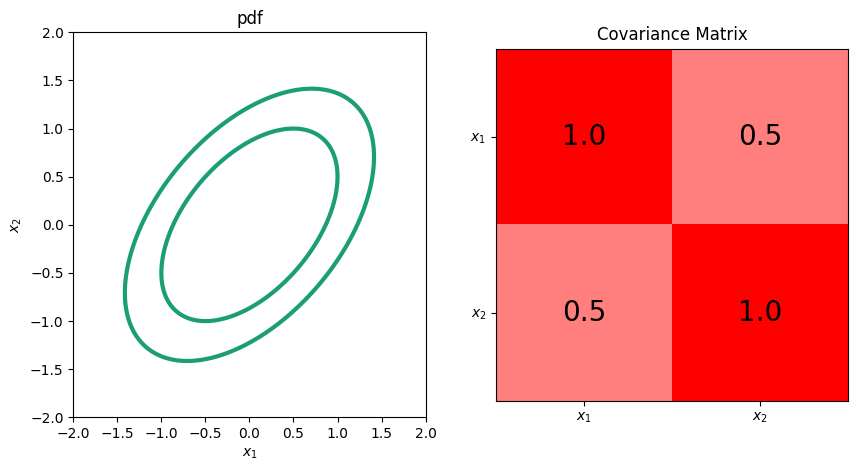

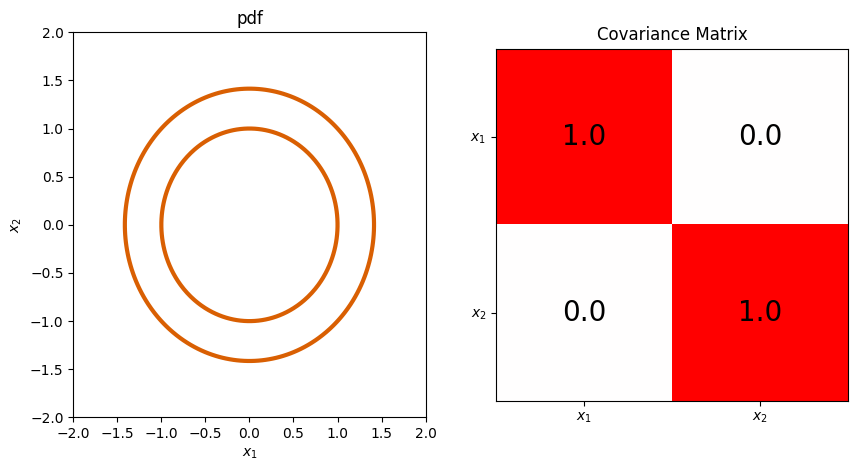

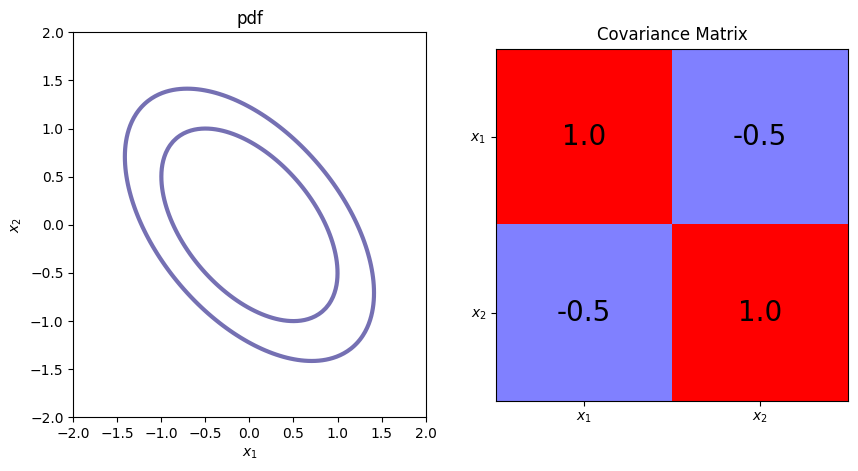

In [231]:
def plot_pdf_and_covariance(covariance_matrix:np.ndarray, color='black'):
    # TODO write the pdf evaluation using the vectorized pdf function.
    pdf_evaluations = mg_pdf_vectorized(x_vec_points, mu_all, covariance_matrix)
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].contour(x1_points, x2_points, pdf_evaluations/np.max(pdf_evaluations), levels=[ np.exp(-1),np.exp(-0.5)], 
                  colors=color, linewidths=3)
    ax[0].set_xlabel(r'$x_1$')
    ax[0].set_ylabel(r'$x_2$')
    ax[0].set_title('pdf')
    ax[1].imshow(covariance_matrix, cmap='bwr', vmax=1, vmin=-1)
    ax[1].set_xticks([0,1])
    ax[1].set_xticklabels([r'$x_1$',r'$x_2$'])
    ax[1].set_yticks([0,1])
    ax[1].set_yticklabels([r'$x_1$',r'$x_2$'])
    ax[1].set_title('Covariance Matrix')

    for x_1 in range(2):
        for x_2 in range(2):
            ax[1].text(x_1, x_2, covariance_matrix[x_1, x_2], fontsize=20, ha='center', va='center')
    
    plt.show()

plot_pdf_and_covariance(cov_one, '#1b9e77')
plot_pdf_and_covariance(cov_two, '#d95f02')
plot_pdf_and_covariance(cov_three, '#7570b3')

Now let's see how conditioning on a specific variable of our multivariate Gaussian changes our distribution. Let's start by writing down the conditioned mean and covariance matrix from class. To keep things simple, we'll just condition on a single variable.

In [300]:
def marginal_mean_covariance(mu_vec: np.ndarray, covariance_matrix: np.ndarray, marginal_index:int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculates the marginalized mean and covariance matrix of a multivariate Gaussian.

    Args:
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.
        marginal_index: Variable index to marginalize on.

    Returns:
        Mean and covariance of marginalized Gaussian.

    Notes:
        The easiest way to do this is to permute the vector and matrix so that the condition_index is the last index.
        Some functions you may find useful beyond the ones you've 
        already used:
        - np.delete
    """
    # TODO calculate the mean and covariance.
    sort_indices = np.arange(len(mu_vec))
    sort_indices[marginal_index] = -1
    sort_indices[-1] = marginal_index

    mu_sort = mu_vec[sort_indices]
    mu_a = mu_sort[:-1]

    covariance_matrix_sort = covariance_matrix[sort_indices][:,sort_indices]
    cov_aa = covariance_matrix_sort[:-1,:-1]

    return mu_a, cov_aa

def conditioned_mean_covariance(mu_vec: np.ndarray, covariance_matrix: np.ndarray, condition_index:int, 
                                condition_value:float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculates the conditioned mean and covariance matrix of a multivariate Gaussian.

    Args:
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.
        conditioned_index: Variable index to condition on.
        conditioned_value: Value of the variable to condition on.

    Returns:
        Mean and covariance of conditioned Gaussian.

    Notes:
        The easiest way to do this is to permute the vector and matrix so that the condition_index is the last index. 
        Some functions you may find useful beyond the ones you've 
        already used:
        - np.delete
        - np.squeeze
    """
    # TODO calculate the mean and covariance.
    sort_indices = np.arange(len(mu_vec))
    sort_indices[condition_index] = -1
    sort_indices[-1] = condition_index

    mu_sort = mu_vec[sort_indices]
    mu_a = mu_sort[:-1]
    mu_b = mu_sort[-1]

    covariance_matrix_sort = covariance_matrix[sort_indices][:,sort_indices]
    cov_aa = covariance_matrix_sort[:-1,:-1]
    cov_ab = covariance_matrix_sort[:-1,-1:]
    cov_bb = covariance_matrix_sort[-1:,-1:]
    
    mu_cond = np.squeeze(mu_a + np.matmul(cov_ab, np.linalg.inv(cov_bb)).T * (condition_value - mu_b))
    cov_cond = cov_aa - np.matmul(cov_ab, np.matmul(np.linalg.inv(cov_bb), cov_ab.T))

    return mu_cond, cov_cond

def conditioned_gaussian_pdf(x_vec: np.ndarray, mu_vec: np.ndarray, covariance_matrix: np.ndarray,
                             condition_index:int, condition_value:float) -> float:
    """
    Calculates the conditioned probability density function of a multivariate Gaussian.

    Args:
        x_vec: Vector at which to evaluate the pdf.
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.
        conditioned_index: Variable index to condition on.
        conditioned_value: Value of the variable to condition on.

    Returns:
        Probability density function value at location x_vec.
    """
    mu_cond, cov_cond = conditioned_mean_covariance(mu_vec, covariance_matrix, condition_index, condition_value)

    return multivariate_gaussian_pdf(x_vec, mu_cond, cov_cond)

def marginal_gaussian_pdf(x_vec: np.ndarray, mu_vec: np.ndarray, covariance_matrix: np.ndarray,
                             marginal_index:int) -> float:
    """
    Calculates the marginalized probability density function of a multivariate Gaussian.

    Args:
        x_vec: Vector at which to evaluate the pdf.
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.
        marginal_index: Variable index to marginalize on.

    Returns:
        Probability density function value at location x_vec.
    """
    mu_marg, cov_marg = marginal_mean_covariance(mu_vec, covariance_matrix, marginal_index)

    return multivariate_gaussian_pdf(x_vec, mu_marg, cov_marg)

In [353]:
# Let's test our functions to make sure they give the right values.
# Test the marginal
mu_four = np.array([0.2, 0.3, -0.2])
cov_four = np.array([[1.0, 0.5, 0.2],[0.5, 1.0, 0.5], [0.2, 0.5, 1.0]])
my_mean, my_covariance = marginal_mean_covariance(mu_four, cov_four, marginal_index=1)
correct_mean, correct_covariance = (np.array([0.2, -0.2]), np.array([[1.0, 0.2],[0.2, 1.0]]))
np.testing.assert_array_almost_equal(my_mean, correct_mean)
np.testing.assert_array_almost_equal(my_covariance, correct_covariance)

# Test the conditional
my_mean, my_covariance = conditioned_mean_covariance(mu_four, cov_four, condition_index=1, condition_value=1.3)
correct_mean, correct_covariance = (np.array([0.7, 0.3]), np.array([[0.75, -0.05],[-0.05, 0.75]]))
np.testing.assert_array_almost_equal(my_mean, correct_mean)
np.testing.assert_array_almost_equal(my_covariance, correct_covariance)

Let's consider our three-dimensional covariance matrix and see how marginalizing changes the distribution.

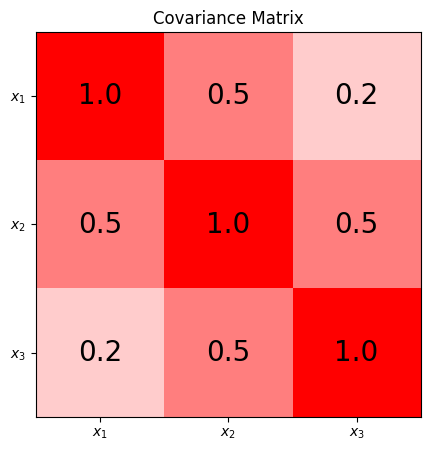

In [354]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(cov_four, cmap='bwr', vmax=1, vmin=-1)
ax.set_xticks([0,1,2])
ax.set_xticklabels([r'$x_1$',r'$x_2$',r'$x_3$'])
ax.set_yticks([0,1,2])
ax.set_yticklabels([r'$x_1$',r'$x_2$',r'$x_3$'])
ax.set_title('Covariance Matrix')

for x_1 in range(3):
    for x_2 in range(3):
        ax.text(x_1, x_2, cov_four[x_1, x_2], fontsize=20, ha='center', va='center')

plt.show()

Stop for a second and think about what you expect when you condition on $x_2$. First, if we condition on a large positive value of $x_2$, how should that change the means of $x_1$ and $x_3$. Second, if we condition on $x_2$, should $x_1$ and $x_3$ become more strongly correlated or anti-correlated?

In [363]:
# TODO: think about it, then write your guess here. You won't be graded on your guess being correct.
assert False

AssertionError: 

In [364]:
# We can use numpy's vectorize capability to vectorize our pdf function.
mg_pdf_vectorized = np.vectorize(marginal_gaussian_pdf, signature='(n), (m), (m,m), () -> ()')
cg_pdf_vectorized = np.vectorize(conditioned_gaussian_pdf, signature='(n), (m), (m,m), (), () -> ()')

# We can also use numpy's meshgrid to get the points to evaluate
x1_points, x3_points = np.meshgrid(np.linspace(-3,3,100), np.linspace(-3,3,100))
x_vec_points = np.stack([x1_points, x3_points], axis=-1)

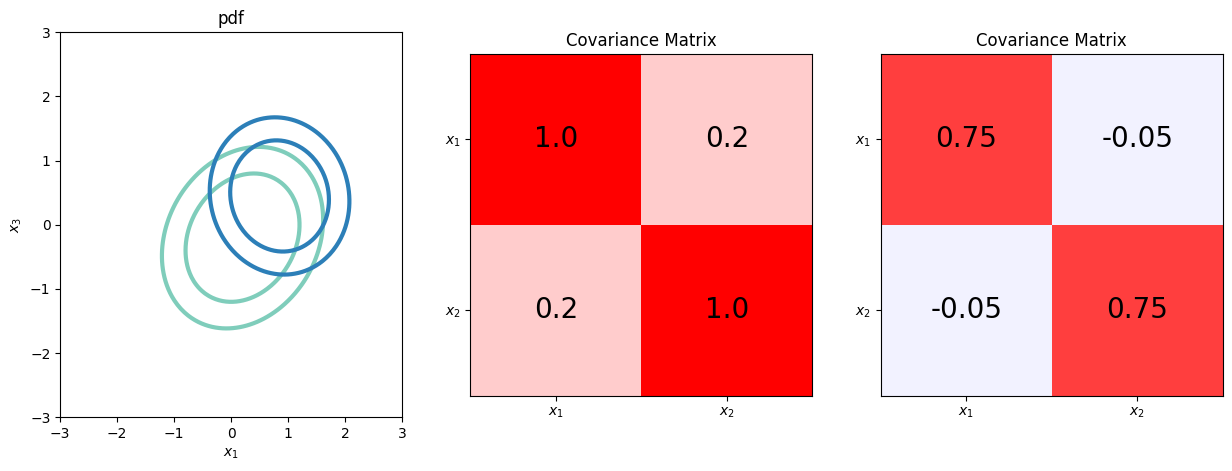

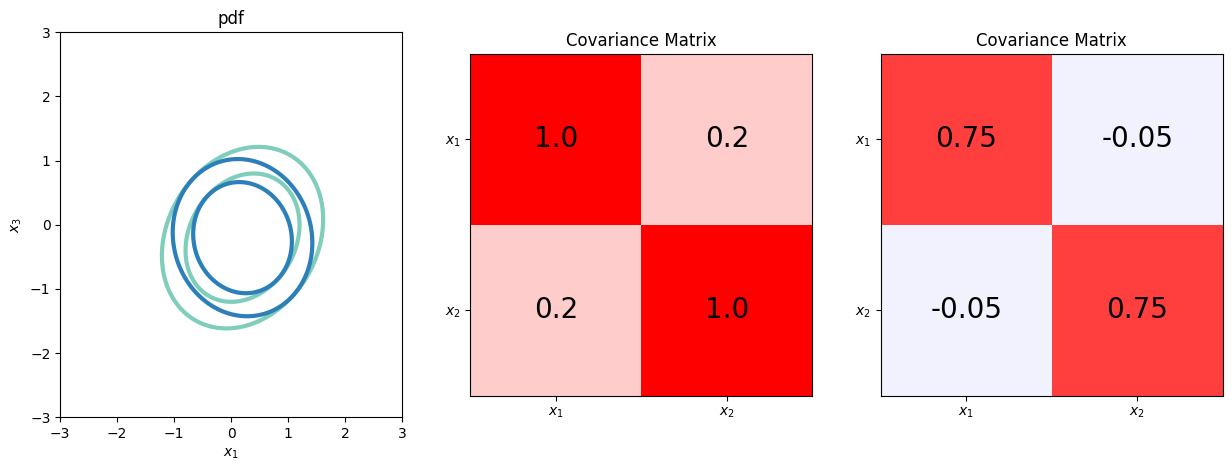

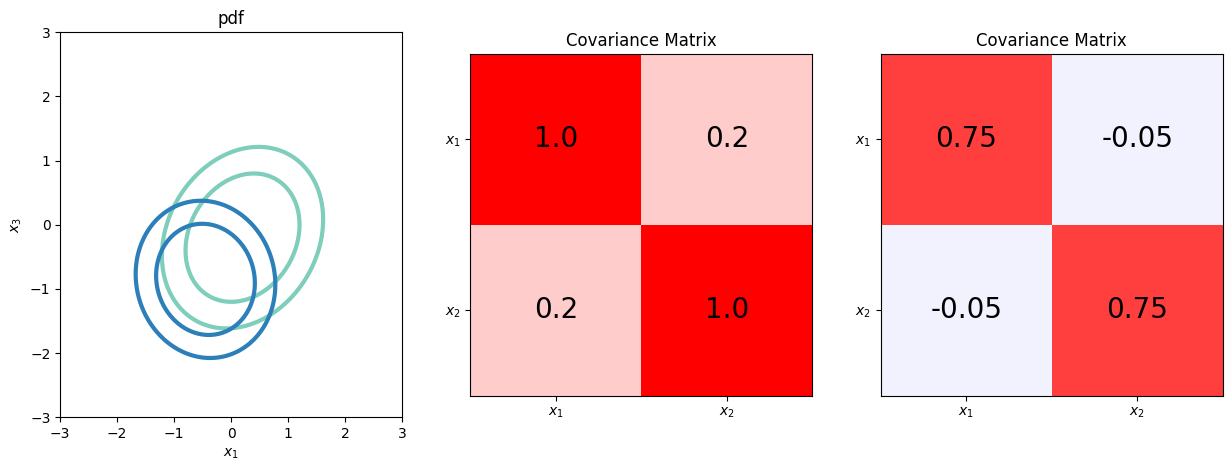

In [365]:
def plot_pdf_and_covariance(conditional_index:int, conditional_value:float):
    # TODO write the pdf evaluation using the vectorized pdf function.
    marginal_evaluations = mg_pdf_vectorized(x_vec_points, mu_four, cov_four, marginal_index=conditional_index)
    conditional_evaluations = cg_pdf_vectorized(x_vec_points, mu_four, cov_four, conditional_index, conditional_value)
    
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].contour(x1_points, x3_points, marginal_evaluations/np.max(marginal_evaluations), levels=[ np.exp(-1),np.exp(-0.5)], 
                  colors='#7fcdbb', linewidths=3)
    ax[0].contour(x1_points, x3_points, conditional_evaluations/np.max(conditional_evaluations), levels=[ np.exp(-1),np.exp(-0.5)], 
                  colors='#2c7fb8', linewidths=3)
    ax[0].set_xlabel(r'$x_1$')
    ax[0].set_ylabel(r'$x_3$')
    ax[0].set_title('pdf')

    _, cov_marginal = marginal_mean_covariance(mu_four, cov_four, marginal_index=conditional_index)
    ax[1].imshow(cov_marginal, cmap='bwr', vmax=1, vmin=-1)
    ax[1].set_xticks([0,1])
    ax[1].set_xticklabels([r'$x_1$',r'$x_2$'])
    ax[1].set_yticks([0,1])
    ax[1].set_yticklabels([r'$x_1$',r'$x_2$'])
    ax[1].set_title('Covariance Matrix')
    for x_1 in range(2):
        for x_3 in range(2):
            ax[1].text(x_1, x_3, cov_marginal[x_1, x_3], fontsize=20, ha='center', va='center')

    _, cov_conditional = conditioned_mean_covariance(mu_four, cov_four, conditional_index, conditional_value)
    ax[2].imshow(cov_conditional, cmap='bwr', vmax=1, vmin=-1)
    ax[2].set_xticks([0,1])
    ax[2].set_xticklabels([r'$x_1$',r'$x_2$'])
    ax[2].set_yticks([0,1])
    ax[2].set_yticklabels([r'$x_1$',r'$x_2$'])
    ax[2].set_title('Covariance Matrix')
    for x_1 in range(2):
        for x_3 in range(2):
            ax[2].text(x_1, x_3, np.round(cov_conditional[x_1, x_3],2), fontsize=20, ha='center', va='center')
    
    plt.show()

plot_pdf_and_covariance(1, 1.6)
plot_pdf_and_covariance(1, 0.3)
plot_pdf_and_covariance(1, -1.0)